Import SCL

In [1]:
import sys
sys.path.append("../stanford_compression_library-main")

from scl.core.data_encoder_decoder import DataDecoder, DataEncoder
from scl.core.data_block import DataBlock
import argparse
from scl.core.prob_dist import ProbabilityDist
from scl.utils.bitarray_utils import BitArray, uint_to_bitarray, bitarray_to_uint
from scl.compressors.huffman_coder import HuffmanEncoder, HuffmanDecoder, HuffmanTree
from scl.core.data_stream import Uint8FileDataStream
from scl.core.encoded_stream import EncodedBlockReader, EncodedBlockWriter
import struct

## EXP1: Convergence Behavior of Apdative Huffman Coding

First run naive Huffman from SCL

In [2]:
import numpy as np
import tqdm
BLOCKSIZE = 5_000_000  # use a huge block size to just encode once
num_bits_naive_huffman = [] # to store number of bits used for each symbol

input_file = "data/sherlock_ascii.txt"
with Uint8FileDataStream(input_file, "rb") as fds:
    data_block = fds.get_block(BLOCKSIZE)
prob_dist = data_block.get_empirical_distribution()
huffman_encoder = HuffmanEncoder(prob_dist)
# read file and get character each time
for symbol in tqdm.tqdm(data_block.data_list):
    encoded_symbol = huffman_encoder.encode_symbol(symbol)
    num_bits_naive_huffman.append(len(encoded_symbol))
print(f"Number of symbols: {len(data_block.data_list)}")

100%|██████████| 362308/362308 [00:00<00:00, 6922480.74it/s]

Number of symbols: 362308


Nest run Apdative Huffman

In [5]:
from scl.compressors.vitter_adaptive_huffman_2 import VitterAdaptiveHuffmanEncoder, VitterAdaptiveHuffmanDecoder
import time
with open(input_file, "rb") as f:
    text = f.read()
num_bits_adaptive = []
t = 0
encoder = VitterAdaptiveHuffmanEncoder()
for byte in tqdm.tqdm(text):
    t += 1
    if byte in encoder.leaves:
        num_bits_adaptive.append(len(encoder.get_code(encoder.leaves[byte])))
        encoder.update(encoder.leaves[byte], byte)
    else:
        num_bits_adaptive.append(len(encoder.get_code(encoder.nyt)) + len(encoder.byte_to_bits(byte)))
        encoder.update(None, byte)

100%|██████████| 362308/362308 [00:00<00:00, 419574.81it/s]


Plot result

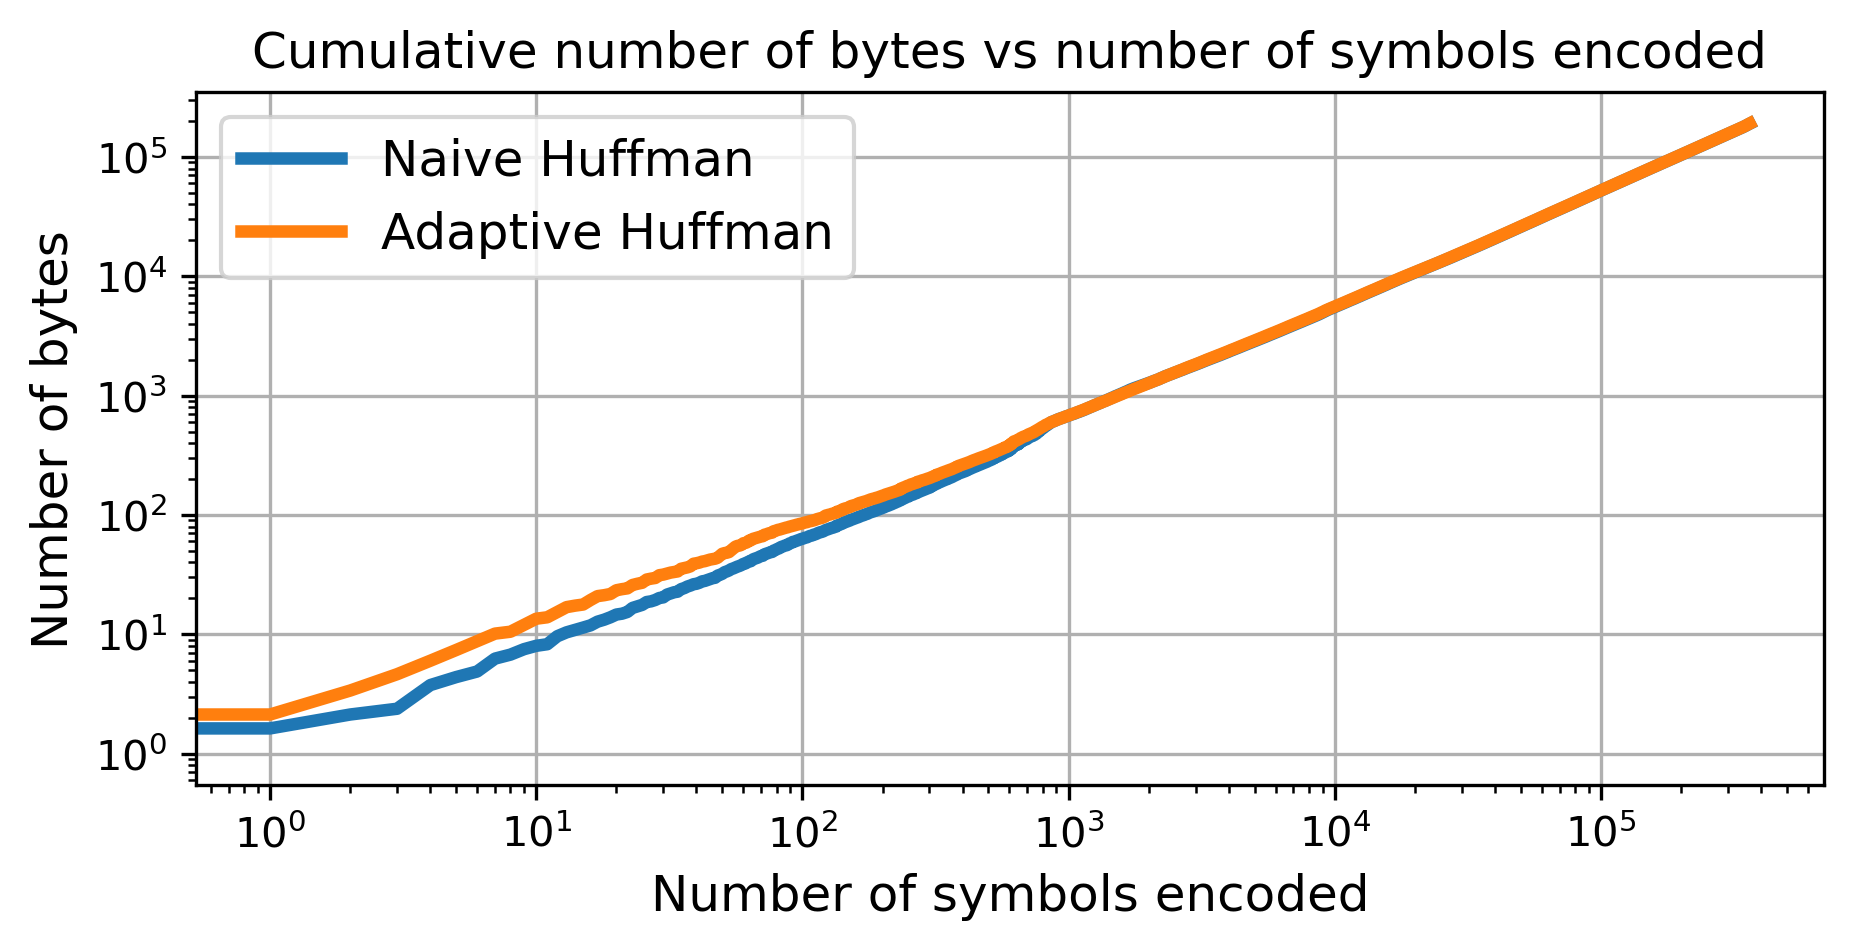

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7,3), dpi=300)
plt.loglog(np.cumsum(num_bits_naive_huffman) / 8, label="Naive Huffman", linewidth=3)
plt.loglog(np.cumsum(num_bits_adaptive) / 8, label="Adaptive Huffman", linewidth=3)

plt.xlabel("Number of symbols encoded", fontsize=12)
plt.ylabel("Number of bytes", fontsize=12)
plt.title("Cumulative number of bytes vs number of symbols encoded", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

## EXP2: Distribution shift

Experiment setup: The Naive Huffman encoder is first learning the distribution from English text. However,the input data contains 10\% of English text and then changes to Korean. Note: the translated version is auto translated and is not guaranteed to be well translated, the purpose is just to get distribution shift.

In [18]:
# naive huffman
input_file_english = "data/sherlock_ascii.txt"
input_file_korean = "data/korean_romanized_normalized.txt"
num_bits_arr = []
with Uint8FileDataStream(input_file_english, "rb") as fds:
    data_block = fds.get_block(BLOCKSIZE)
prob_dist_english = data_block.get_empirical_distribution()
huffman_encoder = HuffmanEncoder(prob_dist_english)
# read file and get character each time
for symbol in tqdm.tqdm(data_block.data_list[0: len(data_block.data_list)//10]):
    encoded_symbol = huffman_encoder.encode_symbol(symbol)
    num_bits_arr.append(len(encoded_symbol))
with Uint8FileDataStream(input_file_korean, "rb") as fds:
    data_block = fds.get_block(BLOCKSIZE)
for symbol in tqdm.tqdm(data_block.data_list):
    # check if symbol in the English prob distribution
    if not symbol in prob_dist_english.prob_dict:
        continue
    encoded_symbol = huffman_encoder.encode_symbol(symbol)
    num_bits_arr.append(len(encoded_symbol))

100%|██████████| 359872/359872 [00:00<00:00, 6158705.80it/s]


In [19]:
# adaptive huffman
with open(input_file_english, "rb") as f:
    text_english = f.read()
text_english = text_english[0: len(text_english)//10]
with open(input_file_korean, "rb") as f:
    text_korean = f.read()
text = text_english + text_korean
num_bits_arr_adaptive = []
t = 0
encoder = VitterAdaptiveHuffmanEncoder()
for byte in text:
    t += 1
    if byte in encoder.leaves:
        num_bits_arr_adaptive.append(len(encoder.get_code(encoder.leaves[byte])))
        encoder.update(encoder.leaves[byte], byte)
    else:
        num_bits_arr_adaptive.append(len(encoder.get_code(encoder.nyt)) + len(encoder.byte_to_bits(byte)))
        encoder.update(None, byte)

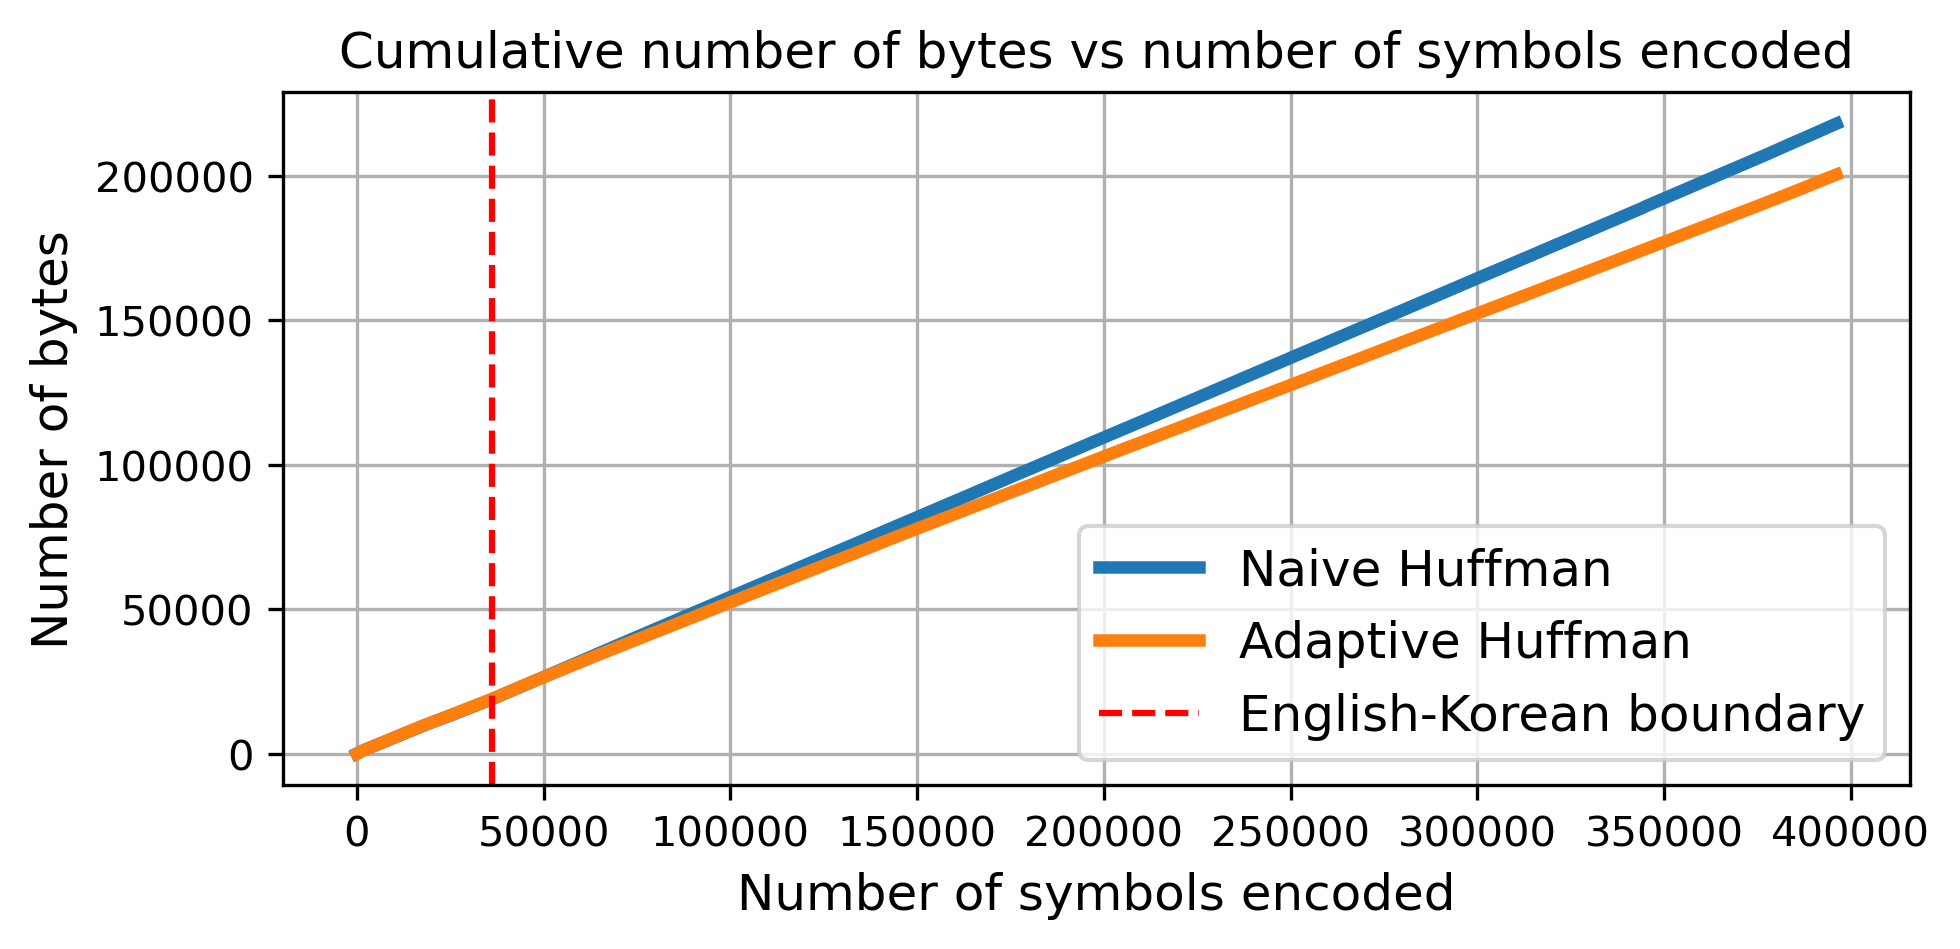

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7,3), dpi=300)
plt.plot(np.cumsum(num_bits_arr) / 8, label="Naive Huffman", linewidth=3)
plt.plot(np.cumsum(num_bits_arr_adaptive) / 8, label="Adaptive Huffman", linewidth=3)
# plot a xline
plt.axvline(x=len(text_english), color='red', linestyle='--', label='English-Korean boundary')
plt.xlabel("Number of symbols encoded", fontsize=12)
plt.ylabel("Number of bytes", fontsize=12)
plt.title("Cumulative number of bytes vs number of symbols encoded", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()